# PySINDy Exploration & Applications

## COLSA Corporation 

### Raj Garkhedkar, DACS Lab Summer 2021 Intern

In [1]:
import pysindy as ps
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import IPython.display as IPdisplay
import seaborn as sns
import scipy.sparse as sparse
import os
import glob
import time
import warnings
import pandas as pd
import pylab as pl
import math
import itertools
import operator
import scipy.misc
import IPython.display as ipdisplay
from numpy.fft import rfft,irfft,rfftfreq
from time import process_time
from scipy.integrate import odeint, solve_ivp
from scipy.fftpack import diff as diffy
from scipy.sparse import dia_matrix, csc_matrix
from sklearn.linear_model import Lasso
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation
from PIL import Image as pil
from PIL import ImageDraw as draw
from subprocess import check_output
from functools import partial
from IPython.core.interactiveshell import InteractiveShell
from IPython import display
from IPython.core.display import Image

%matplotlib inline
warnings.filterwarnings('ignore')
pd.options.display.max_colwidth = 2000
pd.get_option("display.max_columns")
pd.set_option("display.max_columns", None)
family = 'Times New Roman'
title_font = fm.FontProperties(family=family, style='normal', size=20, weight='normal', stretch='normal')

###### Links

[UCSB MATLAB Paper](https://web.math.ucsb.edu/~jhateley/paper/lorenz.pdf)

[NASA Paper on SINDy & ML](https://ntrs.nasa.gov/api/citations/20200001544/downloads/20200001544.pdf) *big file, long loading time

[PySINDy Docs](https://pysindy.readthedocs.io/en/latest/index.html)

[PySINDy Examples (from docs)](https://pysindy.readthedocs.io/en/latest/examples/3_original_paper.html)

[PySINDy Publication - Official Paper](https://www.researchgate.net/publication/340806743_PySINDy_A_Python_package_for_the_Sparse_Identification_of_Nonlinear_Dynamics_from_Data)

[PySINDy GitHub Page](https://github.com/dynamicslab/pysindy)

[PySINDy Syntax & API Docs](https://pysindy.readthedocs.io/en/latest/api/pysindy.html)

[Lorenz FNN GitHub](https://github.com/williamgilpin/fnn)

[Chaos & Attractors](https://blogs.rstudio.com/ai/posts/2020-06-24-deep-attractors/)

[Arxiv of Time Series Reconstruction of Attractors](https://arxiv.org/abs/2002.05909)

[Learning Chaotic Dynamics Arxiv](https://arxiv.org/pdf/1903.10335.pdf)

## Lorenz System

The Lorenz system is a system of ordinary differential equations (ODE's) which has very chaotic solutions based on initial conditions. The Lorenz Attractor is a set of specific chaotic solutions for the Lorenz system which, when plotted, resembles a butterfly. 

Mathematically, the system of equations are: 

$$\frac{dx}{dt} = \sigma(y-x)$$
$$\frac{dy}{dt} = x(\rho - z) - y$$
$$\frac{dz}{dt} = xy + \beta z$$

Below code is a regular NumPy implementation to demonstrate how it's supposed to look. 

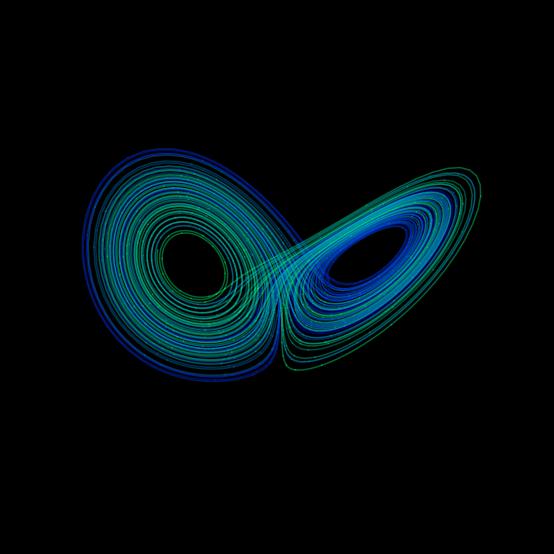

If you wish to mess around with different initial conditions and boundary conditions, unhash the `input` code above


In [2]:
WIDTH, HEIGHT, DPI = 1000, 750, 100

# Unhash below to play around with different values

# sigma = float(input("Enter A Number: "))
# beta = float(input("Enter A Number: "))
# rho = float(input("Enter A Number: "))

# u0 = float(input("Enter An Initial Condition Number: "))
# v0 = float(input("Enter An Initial Condition Number: "))
# w0 = float(input("Enter An Initial Condition Number: "))


# Lorenz paramters and initial conditions.
sigma = 10
beta = 2.66667
rho = 28
u0 = -8
v0 = 8
w0 = 27

# Maximum time point and total number of time points.
tmax, n = 100, 10000

def lorenz(t, X, sigma, beta, rho):
    """The Lorenz equations."""
    x, y, z = X
    dx = - sigma * (x - y)
    dy = rho * x - y - x * z
    dz = - beta * z + x * y
    return dx, dy, dz

# Integrate the Lorenz equations.
soln = solve_ivp(lorenz, (0, tmax), (u0, v0, w0), args=(sigma, beta, rho),
                 dense_output=True)
# Interpolate solution onto the time grid, t.
t = np.linspace(0, tmax, n)
x, y, z = soln.sol(t)

# Plot the Lorenz attractor using a Matplotlib 3D projection.
fig = plt.figure(facecolor='k', figsize=(WIDTH/DPI, HEIGHT/DPI))
ax = fig.gca(projection='3d')
ax.set_facecolor('k')
fig.subplots_adjust(left=0, right=1, bottom=0, top=1)

# Make the line multi-coloured by plotting it in segments of length s which
# change in color across the whole time series.
s = 10
cmap = plt.cm.winter
for i in range(0,n-s,s):
    ax.plot(x[i:i+s+1], y[i:i+s+1], z[i:i+s+1], color=cmap(i/n), alpha=0.4)
ax.set_axis_off()
plt.show()

print('If you wish to mess around with different initial conditions and boundary conditions, unhash the `input` code above')

So that's what it looks like with what the conditions/parameters I input... looks cool (or bad, yikes)

Hint (enter the following, in order, for a cool attractor):
`10`
`2.66667`
`28`
`-8`
`8`
`27`
OR
`20`
`6.7435`
`80`
`2`
`2`
`2`

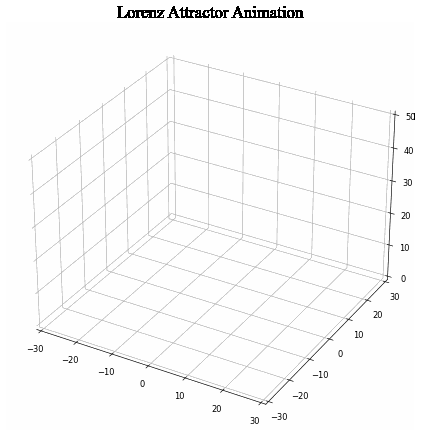

In [3]:
# Burner folder to temporary store images
folder = '/Users/rajgark/Desktop/PySINDy/AttractorImages' 

# Function for lorenz system
def lorenz_animated(current_state, t):
    x, y, z = current_state
    dx_dt = sigma * (y - x)
    dy_dt = x * (rho - z) - y
    dz_dt = x * y - beta * z
    return [dx_dt, dy_dt, dz_dt]

def plot_lorenz(xyz, n):
    fig = plt.figure(figsize=(12, 9))
    ax = fig.gca(projection='3d')
    ax.xaxis.set_pane_color((1,1,1,1))
    ax.yaxis.set_pane_color((1,1,1,1))
    ax.zaxis.set_pane_color((1,1,1,1))
    x = xyz[:, 0]
    y = xyz[:, 1]
    z = xyz[:, 2]
    ax.plot(x, y, z, color='g', alpha=0.7, linewidth=0.7)
    ax.set_xlim((-30,30))
    ax.set_ylim((-30,30))
    ax.set_zlim((0,50))
    ax.set_title('Lorenz Attractor Animation', fontproperties=title_font)
    
    plt.savefig('{}/{:03d}.png'.format(folder, n), dpi=60, bbox_inches='tight', pad_inches=0.1)
    plt.close()
    
    
def chunky(full_list, size):
    size = max(1,size)
    chunks = [full_list[0:i] for i in range(1,len(full_list) + 1, size)]
    return chunks

start = 0
end = 60
interval = 100
initial_state = [0.1,0,0]
timepoints = np.linspace(start, end, end*interval)
chunks = chunky(timepoints, size = 20)
points = [odeint(lorenz_animated, initial_state, chunk) for chunk in chunks ]
for n, point in enumerate(points):
    plot_lorenz(point, n)
    

fp_in = '/Users/rajgark/Desktop/PySINDy/AttractorImages/*.png'
fp_out = '/Users/rajgark/Desktop/PySINDy/AttractorImages/attractorgif.gif'

img, *imgs = [pil.open(f) for f in sorted(glob.glob(fp_in))]
img.save(fp = fp_out, format = 'gif', append_images = imgs, save_all = True, duration = 200, loop = 0)
IPdisplay.Image('/Users/rajgark/Desktop/PySINDy/AttractorImages/attractorgif.gif')

In [4]:
# Deletes all images captured to make gif
files = glob.glob('/Users/rajgark/Desktop/PySINDy/AttractorImages/*')
for f in files:
    os.remove(f)

## Lorenz  Attractor w/ PySINDy Implementation

This PySINDy implementation is guided by the original docs.

In [5]:
def sindylorenz(x, t):
    return [
        10 * (x[1] - x[0]),
        x[0] * (28 - x[2]) - x[1],
        x[0] * x[1] - 8 / 3 * x[2],
    ]
dt = 0.001
t_train = np.arange(0,100,dt)
print('t_train size: ',t_train.size)
x0_train = [-8, 8, 27] 
x_train = odeint(sindylorenz, x0_train, t_train)
x_dot_train_measured = np.array([sindylorenz(x_train[i], 0) for i in range(t_train.size)])

t_train size:  100000


In [6]:
x_train.shape

(100000, 3)

In [7]:
x_dot_train_measured

array([[ 160.        ,  -16.        , -136.        ],
       [ 158.24431979,  -16.8838717 , -134.23775957],
       [ 156.49758905,  -17.71263697, -132.49280262],
       ...,
       [ -28.72624609,  -51.10615231,   -1.43648445],
       [ -28.95031074,  -51.38316607,   -0.9237215 ],
       [ -29.17489996,  -51.65971009,   -0.40603218]])

In [8]:
polynomial_order = 5
threshold = 0.05
seed = 100
np.random.seed(seed)

optimize = ps.STLSQ(threshold = threshold)
featurelib = ps.PolynomialLibrary(degree = polynomial_order)

model = ps.SINDy(optimizer = optimize, feature_library = featurelib)
model.fit(x_train, t = dt, x_dot = x_dot_train_measured + np.random.normal(size = x_train.shape), quiet = True)
#models = []
#tsim = np.arange(0,20,dt)
#xsim = []
#noises = [1e-3, 1e-3, 1e-2, 1e-1, 1.0]

# for eps in noises:
#     model = ps.SINDy(optimizer = optimize, feature_library = featurelib)
#     model.fit(x_train, t = dt, x_dot = x_dot_train_measured + np.random.normal(scale = eps, size = x_train.shape), quiet = True)
#     models.append(model)
#     xsim.append(model.simulate(x_train[0], tsim))

SINDy(differentiation_method=FiniteDifference(),
      feature_library=PolynomialLibrary(degree=5),
      feature_names=['x0', 'x1', 'x2'], optimizer=STLSQ(threshold=0.05))

The hashed out code is from the docs, I had it to debug. The optimizer actually can choose random values so it's important to make sure the notebook is seeded for reproducibility.

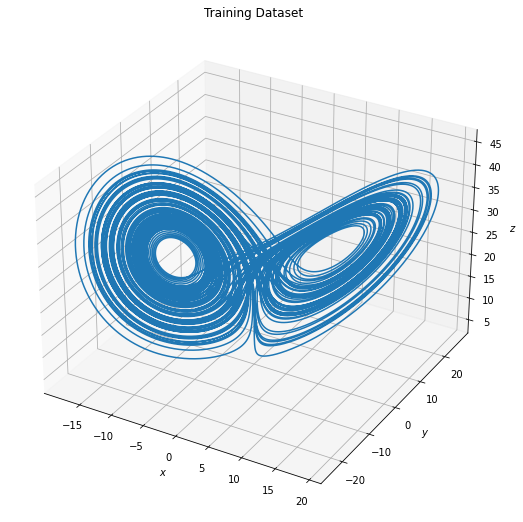

In [9]:
fig = plt.figure(figsize=(30, 15))
ax = fig.add_subplot(131, projection="3d")
ax.plot(
    x_train[: t_train.size, 0],
    x_train[: t_train.size, 1],
    x_train[: t_train.size, 2],
)
plt.title("Training Dataset")
ax.set(xlabel="$x$", ylabel="$y$", zlabel="$z$")
fig.show()

To preface the above plot, I should say that I'm not sure what it will look like everytime the notebook is run. All of yesterday, 10 June, I went over my code ~ 35 times to ensure everything is working as it should, and the output of PySINDy attractor above was just one line and one swirl. Then in the morning on 11 June I ran the notebook and it actually looks like how the system should. It doesn't quite look exactly like Prof. Brunton's on the PySINDy docs, but it does look like a Lorenz attractor. 

In [10]:
model.print()

x0' = -9.998 x0 + 9.998 x1
x1' = 28.001 x0 + -1.001 x1 + -1.000 x0 x2
x2' = -2.666 x2 + 1.000 x0 x1


`x0' = -9.998 x0 + 9.998 x1
x1' = 28.001 x0 + -1.001 x1 + -1.000 x0 x2
x2' = -2.666 x2 + 1.000 x0 x1`

Those should be the outputs of the above cell, this is with an optimizer and feature library

In [11]:
t_test = np.arange(0, 15, dt)
x0_test = np.array([-8,7,15])
x_test = odeint(sindylorenz, x0_test, t_test)

Above I've done a test set on a trajectory guided through the discovery made in the train set. The initial conditions are different here, so an approximation made here, if accurate, means the model is behaving like a good guy

In [12]:
t_test.size

15000

In [13]:
x_test.size

45000

Ignore above output, done for my testing.

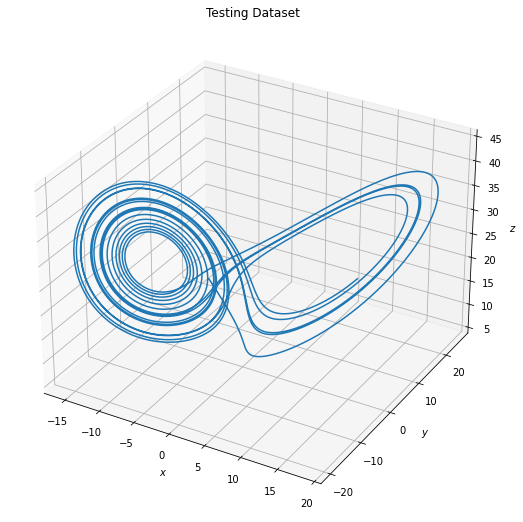

In [14]:
fig = plt.figure(figsize=(30, 15))
ax = fig.add_subplot(131, projection="3d")
ax.plot(
    x_test[: t_test.size, 0],
    x_test[: t_test.size, 1],
    x_test[: t_test.size, 2],
)
plt.title("Testing Dataset")
ax.set(xlabel="$x$", ylabel="$y$", zlabel="$z$")
fig.show()

The goal now will be to leverage the training dataset and testing dataset to make a simulation which goes forward in time accurately projecting the trajectory of the chaotic particles.
<br> 
After doing so, a neural network can be implemented (as done in DDSE pg. 216 by Brunton & Kutz) to create a robust system for modeling the lorenz system of equations.

### My Implementation

In [15]:
newdt = 0.002

t_trainset = np.arange(0, 100, newdt)
x0_trainset = [-8, 8, 27]
x_trainset = odeint(sindylorenz, x0_trainset, t_trainset)

newmodel = ps.SINDy()
newmodel.fit(x_trainset, t = newdt)
newmodel.print()

x0' = -9.999 x0 + 9.999 x1
x1' = 27.992 x0 + -0.998 x1 + -1.000 x0 x2
x2' = -2.666 x2 + 1.000 x0 x1


I'm creating a new train/test split here with different variables to play around with. 

Model score: 1.000000


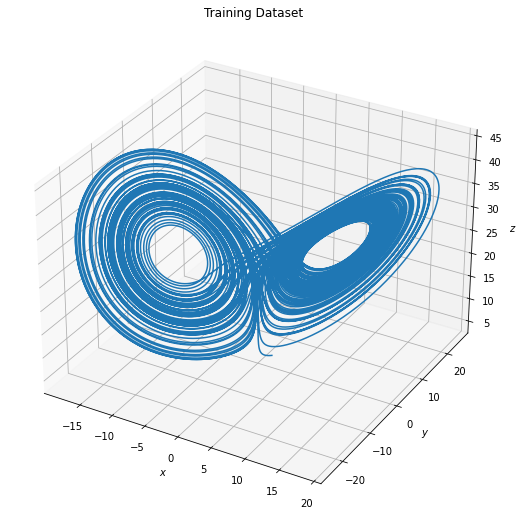

In [16]:
t_testset = np.arange(0, 15, newdt)
x0_testset = np.array([8, 7, 15])
x_testset = odeint(sindylorenz, x0_testset, t_testset)

print('Model score: %f' % model.score(x_testset, t = newdt))

fig = plt.figure(figsize=(30, 20))
ax = fig.add_subplot(131, projection="3d")
ax.plot(
    x_trainset[: t_trainset.size, 0],
    x_trainset[: t_trainset.size, 1],
    x_trainset[: t_trainset.size, 2],
)
plt.title("Training Dataset")
ax.set(xlabel="$x$", ylabel="$y$", zlabel="$z$")
fig.show()

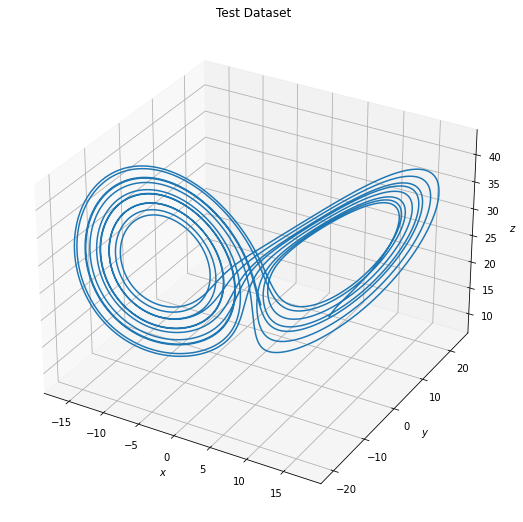

In [17]:
fig = plt.figure(figsize=(30, 15))
ax = fig.add_subplot(131, projection="3d")
ax.plot(
    x_testset[: t_testset.size, 0],
    x_testset[: t_testset.size, 1],
    x_testset[: t_testset.size, 2],
)
# ax.plot(
#      x_trainset[: t_trainset.size, 0],
#      x_trainset[: t_trainset.size, 1],
#      x_trainset[: t_trainset.size, 2],
# )
plt.title("Test Dataset")
ax.set(xlabel="$x$", ylabel="$y$", zlabel="$z$")
fig.show()

The test system above is with a smaller dataset and different initial conditions

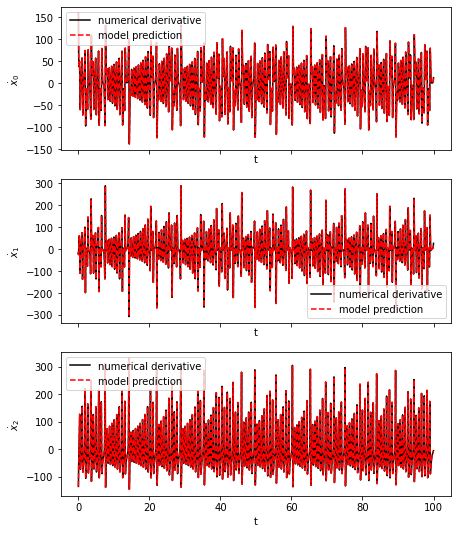

In [18]:
x_dot_train_pred = newmodel.predict(x_trainset)

x_dot_train_comp = newmodel.differentiate(x_trainset, t = newdt)

fig, axs = plt.subplots(x_trainset.shape[1], 1, sharex=True, figsize=(7, 9))
for i in range(x_trainset.shape[1]):
    axs[i].plot(t_trainset, x_dot_train_comp[:, i],
                'k', label='numerical derivative')
    axs[i].plot(t_trainset, x_dot_train_pred[:, i],
                'r--', label='model prediction')
    axs[i].legend()
    axs[i].set(xlabel='t', ylabel='$\dot x_{}$'.format(i))
fig.show()

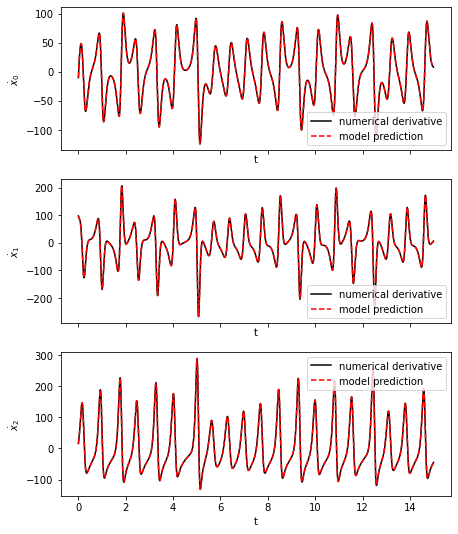

In [19]:
x_dot_test_pred = newmodel.predict(x_testset)

x_dot_test_comp = newmodel.differentiate(x_testset, t = newdt)

fig, axs = plt.subplots(x_testset.shape[1], 1, sharex=True, figsize=(7, 9))
for i in range(x_testset.shape[1]):
    axs[i].plot(t_testset, x_dot_test_comp[:, i],
                'k', label='numerical derivative')
    axs[i].plot(t_testset, x_dot_test_pred[:, i],
                'r--', label='model prediction')
    axs[i].legend()
    axs[i].set(xlabel='t', ylabel='$\dot x_{}$'.format(i))
fig.show()

In [20]:
x_test_sim = newmodel.simulate(x0_testset, t_testset)
x_test_sim.shape

(7500, 3)

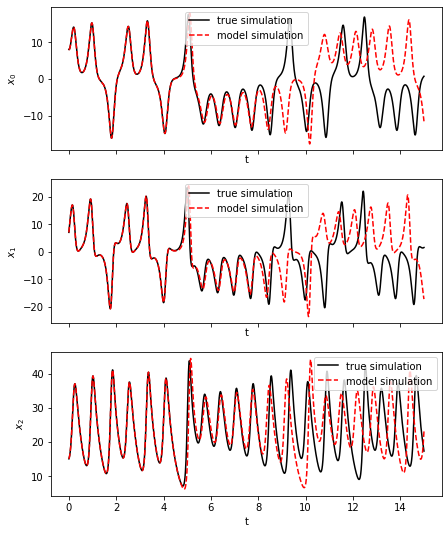

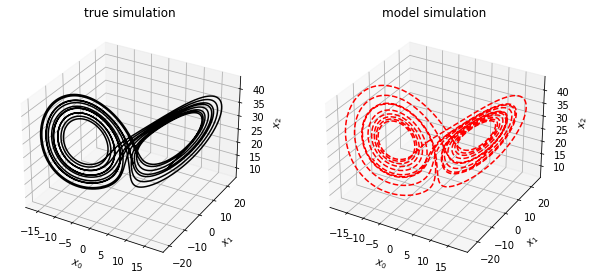

In [21]:
fig, axs = plt.subplots(x_testset.shape[1], 1, sharex=True, figsize=(7, 9))
for i in range(x_testset.shape[1]):
    axs[i].plot(t_testset, x_testset[:, i], 'k', label='true simulation')
    axs[i].plot(t_testset, x_test_sim[:, i], 'r--', label='model simulation')
    axs[i].legend()
    axs[i].set(xlabel='t', ylabel='$x_{}$'.format(i))

fig = plt.figure(figsize=(10, 4.5))
ax1 = fig.add_subplot(121, projection='3d')
ax1.plot(x_testset[:, 0], x_testset[:, 1], x_testset[:, 2], 'k')
ax1.set(xlabel='$x_0$', ylabel='$x_1$',
        zlabel='$x_2$', title='true simulation')

ax2 = fig.add_subplot(122, projection='3d')
ax2.plot(x_test_sim[:, 0], x_test_sim[:, 1], x_test_sim[:, 2], 'r--')
ax2.set(xlabel='$x_0$', ylabel='$x_1$',
        zlabel='$x_2$', title='model simulation')

fig.show()

### Compute $x$ derivatives & measure those states

In [33]:
polynomial_order = 5
threshold = 0.05
seed = 100
np.random.seed(seed)

t_sim = np.arange(0, 20, newdt)
garbmodel = ps.SINDy(optimizer = optimize, feature_library = featurelib)
garbmodel.fit(x_trainset + np.random.normal(size = x_trainset.shape), t = newdt, quiet = True)
x_sim_nod = garbmodel.simulate(x_trainset[0], t_sim)

x_dot_train_measured_new = np.array([sindylorenz(x_trainset[i], 0) for i in range(t_trainset.size)])

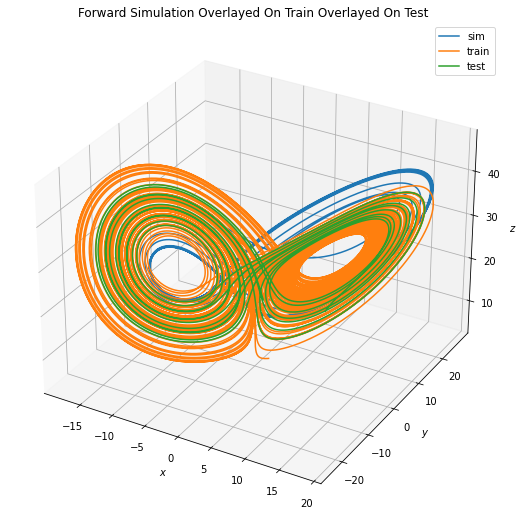

In [34]:
fig = plt.figure(figsize=(30, 15))
ax = fig.add_subplot(131, projection="3d")
# Blue
pl1 = ax.plot(
    x_sim_nod[: t_sim.size, 0],
    x_sim_nod[: t_sim.size, 1],
    x_sim_nod[: t_sim.size, 2],
    label='sim'
)
# Orange
pl2 = ax.plot(
    x_trainset[: t_trainset.size, 0],
    x_trainset[: t_trainset.size, 1],
    x_trainset[: t_trainset.size, 2],
    label='train'
)
# Green
pl3 = ax.plot(
    x_testset[: t_testset.size, 0],
    x_testset[: t_testset.size, 1],
    x_testset[: t_testset.size, 2],
    label='test'
)
plt.title("Forward Simulation Overlayed On Train Overlayed On Test")
ax.set(xlabel="$x$", ylabel="$y$", zlabel="$z$")
#ax.legend([pl1, pl2, pl3], ['Sim','Train','Test'])
ax.legend()
fig.show()

The training and simulation show a semblance of similarity, meaning the algorithm is needs a bit of tuning. I need to attempt this again with noise.

In [40]:
polynomial = 5
threshold = 0.05
seed = 100
np.random.seed(seed)
optimize = ps.STLSQ(threshold = threshold)
featurelib = ps.PolynomialLibrary(degree = polynomial_order)

noise_levels = [1e-4, 1e-3, 1e-2, 1e-1, 1.0]
model_list = []
t_sim_new = np.arange(0, 20, dt) # change to newdt for 0.02 instead, if necessary. 
x_sim_new = []
for eps in noise_levels:
    modelforlist = ps.SINDy(
        optimizer=ps.STLSQ(threshold=threshold),
        feature_library=ps.PolynomialLibrary(degree=polynomial),
    )
    modelforlist.fit(
        x_trainset,
        t=dt,# Likewise, change to newdt if necessary
        x_dot=x_dot_train_measured_new
        + np.random.normal(scale=eps, size=x_trainset.shape),
        quiet=True,
    )
    model_list.append(modelforlist)
    x_sim_new.append(model.simulate(x_trainset[0], t_sim_new))


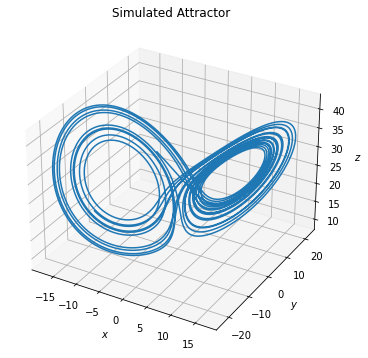

In [41]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(131, projection="3d")
model_idx = 2
ax.plot(
    x_sim_new[model_idx][:, 0],
    x_sim_new[model_idx][:, 1],
    x_sim_new[model_idx][:, 2],
)
plt.title("Simulated Attractor")
ax.set(xlabel="$x$", ylabel="$y$", zlabel="$z$")
plt.show()

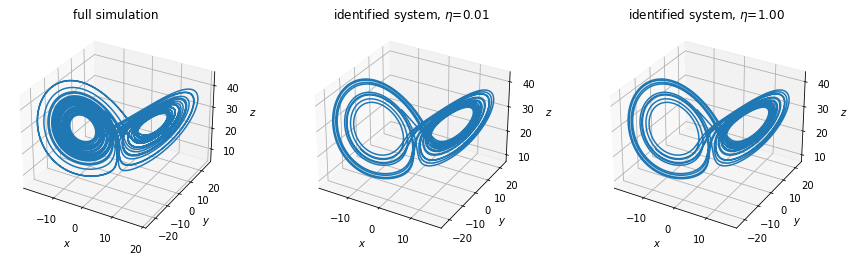

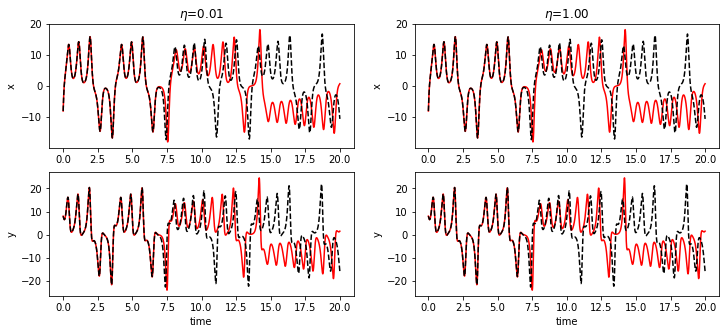

In [42]:
# Plot results

fig = plt.figure(figsize=(15, 4))
ax = fig.add_subplot(131, projection="3d")
ax.plot(
    x_trainset[: t_sim_new.size, 0],
    x_trainset[: t_sim_new.size, 1],
    x_trainset[: t_sim_new.size, 2],
)
plt.title("full simulation")
ax.set(xlabel="$x$", ylabel="$y$", zlabel="$z$")

model_idx = 2
ax = fig.add_subplot(132, projection="3d")
ax.plot(x_sim_new[model_idx][:, 0], x_sim_new[model_idx][:, 1], x_sim_new[model_idx][:, 2])
plt.title(f"identified system, $\eta$={noise_levels[model_idx]:.2f}")
ax.set(xlabel="$x$", ylabel="$y$", zlabel="$z$")

model_idx = 4
ax = fig.add_subplot(133, projection="3d")
ax.plot(x_sim_new[model_idx][:, 0], x_sim_new[model_idx][:, 1], x_sim_new[model_idx][:, 2])
plt.title(f"identified system, $\eta$={noise_levels[model_idx]:.2f}")
ax.set(xlabel="$x$", ylabel="$y$", zlabel="$z$")

fig = plt.figure(figsize=(12, 5))
model_idx = 2
ax = fig.add_subplot(221)
ax.plot(t_sim_new, x_train[: t_sim_new.size, 0], "r")
ax.plot(t_sim_new, x_sim_new[model_idx][:, 0], "k--")
plt.title(f"$\eta$={noise_levels[model_idx]:.2f}")
plt.ylabel("x")

ax = fig.add_subplot(223)
ax.plot(t_sim_new, x_train[: t_sim_new.size, 1], "r")
ax.plot(t_sim_new, x_sim_new[model_idx][:, 1], "k--")
plt.xlabel("time")
plt.ylabel("y")

model_idx = 4
ax = fig.add_subplot(222)
ax.plot(t_sim_new, x_train[: t_sim_new.size, 0], "r")
ax.plot(t_sim_new, x_sim_new[model_idx][:, 0], "k--")
plt.title(f"$\eta$={noise_levels[model_idx]:.2f}")
plt.ylabel("x")

ax = fig.add_subplot(224)
ax.plot(t_sim_new, x_train[: t_sim_new.size, 1], "r")
ax.plot(t_sim_new, x_sim_new[model_idx][:, 1], "k--")
plt.xlabel("time")
plt.ylabel("y")

fig.show()

### Multiple Trajectories w/ Different Time Measurements

In [27]:
n_trajectories = 50

x0s = np.array([36, 48, 41]) * (np.random.rand(n_trajectories, 3) -0.5) + np.array([0,0,25])
x_train_multi = []
t_train_multi = []

for i in range(n_trajectories):
    n_samples = np.random.randint(250,3000)
    t = np.arange(0, n_samples * newdt, newdt)
    x_train_multi.append(odeint(sindylorenz, x0s[i], t))
    t_train_multi.append(t)

model = ps.SINDy()
model.fit(x_train_multi, t = newdt, multiple_trajectories = True)
model.print()

x0' = -9.999 x0 + 9.999 x1
x1' = 27.993 x0 + -0.999 x1 + -1.000 x0 x2
x2' = -2.666 x2 + 1.000 x0 x1


In [28]:
print('Multi-trajectory array shape: ',np.shape(x_train_multi))
t_train_multi

Multi-trajectory array shape:  (50,)


[array([0.   , 0.002, 0.004, 0.006, 0.008, 0.01 , 0.012, 0.014, 0.016,
        0.018, 0.02 , 0.022, 0.024, 0.026, 0.028, 0.03 , 0.032, 0.034,
        0.036, 0.038, 0.04 , 0.042, 0.044, 0.046, 0.048, 0.05 , 0.052,
        0.054, 0.056, 0.058, 0.06 , 0.062, 0.064, 0.066, 0.068, 0.07 ,
        0.072, 0.074, 0.076, 0.078, 0.08 , 0.082, 0.084, 0.086, 0.088,
        0.09 , 0.092, 0.094, 0.096, 0.098, 0.1  , 0.102, 0.104, 0.106,
        0.108, 0.11 , 0.112, 0.114, 0.116, 0.118, 0.12 , 0.122, 0.124,
        0.126, 0.128, 0.13 , 0.132, 0.134, 0.136, 0.138, 0.14 , 0.142,
        0.144, 0.146, 0.148, 0.15 , 0.152, 0.154, 0.156, 0.158, 0.16 ,
        0.162, 0.164, 0.166, 0.168, 0.17 , 0.172, 0.174, 0.176, 0.178,
        0.18 , 0.182, 0.184, 0.186, 0.188, 0.19 , 0.192, 0.194, 0.196,
        0.198, 0.2  , 0.202, 0.204, 0.206, 0.208, 0.21 , 0.212, 0.214,
        0.216, 0.218, 0.22 , 0.222, 0.224, 0.226, 0.228, 0.23 , 0.232,
        0.234, 0.236, 0.238, 0.24 , 0.242, 0.244, 0.246, 0.248, 0.25 ,
      

In [29]:
def multi_traj_plot(particle_ID):
    fig = plt.figure(figsize=(30, 15))
    ax = fig.add_subplot(131, projection="3d")
    multi_idx = particle_ID
    ax.plot(
        x_train_multi[multi_idx][: t_train_multi[multi_idx].size, 0],
        x_train_multi[multi_idx][: t_train_multi[multi_idx].size, 1],
        x_train_multi[multi_idx][: t_train_multi[multi_idx].size, 2],
    )
    plt.title("Training Dataset")
    ax.set(xlabel="$x$", ylabel="$y$", zlabel="$z$")
    fig.show()

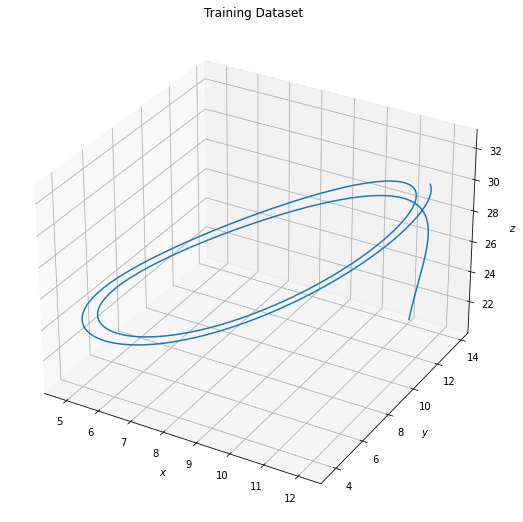

In [30]:
multi_traj_plot(19)

There are 50 (0-49) particles with random trajectories in the variable `x_train_multi` and to show the particle trajectory for any one of your choice, simply enter a number, 0-19, into the argument for the function `multi_traj_plot(enter#here)` 
<br>
The array consists of 20 particles with unique trajectories and times, so there is a very high likelihood of the selected pattern being obscure rather than a good looking attractor. This is due to the sampling rate being multiplied by `newdt` so regardless of the number, the infinitesimal increase dictates the shape of the array. Leaving it to the value it's set at is the best for reproducing valid data throughout the notebook, but newdt can be reassigned on the top of the cell right under the new multi-trajectory section if desired, being sure to hash it out while executing the notebook again.

### Lorenz System Neural Network w/ a Control Input

Since PySINDy has been implemented for model prediction & simulation, the next step is to create a neural network to predict the dynamical system's evolution spatially & temporally. The variable at hand is $x(t)$ where $x$ is the state of the system at time $t$, and the prediction (output) is $y(t+dt)$, or the state of the system after some infinitesimal time $dt$.